## The general workflow with TensorFlow: 

### Construct model --> Compile model --> Fit (train) model with data --> Predict outputs

In [77]:
# to suppress TF warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)

In [78]:
# Numpy implementation of the softmax function (generalization of logistic regression for multi-class cases)
def my_softmax(z):  
    """ Softmax converts a vector of values to a probability distribution.
    Args:
      z (ndarray (N,))  : input data, N features
    Returns:
      a (ndarray (N,))  : softmax of z
    """    

    e_z = np.exp(z)
    a = e_z / np.sum(e_z, axis=0)

    return a

z = np.array([1., 2., 3., 4.])
# softmax using manual numpy implementation
a = my_softmax(z)
# softmax using tensorflow
atf = tf.nn.softmax(z)

print(f"my_softmax(z):         {a}")
print(f"tensorflow softmax(z): {atf}")

my_softmax(z):         [0.03 0.09 0.24 0.64]
tensorflow softmax(z): [0.03 0.09 0.24 0.64]


X.shape: (5000, 400), y.shape: (5000, 1)
X[0] image label is  [0]


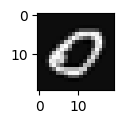

In [79]:
# load dataset
# X are 5000 images of handwritten digits, each is 20x20 pixel grayscale image, unrolled into an 400 element vector
# y are labels for what digit each image represents
X = np.load("data/X.npy")
y = np.load("data/y.npy")

# check shapes
print(f'X.shape: {X.shape}, y.shape: {y.shape}')
# Checkout one image and its label (reshape into original image size first, and show using a gray cmap)
plt.figure(figsize = (1,1))
plt.imshow(X[0].reshape(20,20), cmap='gray')
print('X[0] image label is ', y[0])
plt.show()

### A function to display an image dataset in a grid with labels and optionally prediction results

In [80]:
def show_image_grid(image_set, y, grid_w=8, grid_h=8, random_index=False, show_predictions=False):
    """
    Show a sample of images a long with their labels.
    random_index: Whether to choose images randomly from the passed image data set
    show_predictions: whether to pass images to the model for prediction and show the prediction results too
    grid_w, grid_h : maximum height and width of the image grid
    """
    img_count = image_set.shape[0]
    if img_count <= grid_w:
        grid_w = img_count
        grid_h = 1
    else:
        grid_h = min(int(img_count/grid_w), grid_h)

    fig, axes = plt.subplots(grid_h, grid_w, figsize=(min(grid_w, 5), min(grid_h, 5)))
    fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

    for i,ax in enumerate(axes.flat):
        if random_index:
            # Select random indices
            index = np.random.randint(img_count)
        else:
            index = i

        # Select rows corresponding to the random indices and
        # reshape the image
        X_random_reshaped = image_set[index].reshape((20,20)).T

        # Display the image
        ax.imshow(X_random_reshaped, cmap='gray')
        if(show_predictions):
            # Predict using the Neural Network
            prediction = model.predict(image_set[index].reshape(1,400))
            prediction_p = tf.nn.softmax(prediction)
            yhat = np.argmax(prediction_p)
            # Display the label above the image
            ax.set_title(f"{y[index,0]},{yhat}",fontsize=10)
        else:
            # Display the label above the image
            ax.set_title(f"{y[index,0]}",fontsize=10)
        ax.set_axis_off()
    if(show_predictions):
        fig.suptitle("Label, yhat", fontsize=14)
    else:
        fig.suptitle("Label", fontsize=14)
    plt.show()

### Display a sample of the images and their labels in a grid

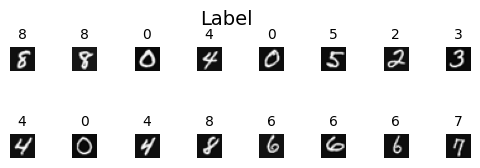

In [81]:
# Choose images randomly and print them in a grid with their labels
show_image_grid(X, y, grid_w=8, grid_h=2, random_index=True, show_predictions=False)

### The NN model to use in this project

    
<img src="images/C2_W2_Assigment_NN.png" width="600" height="450">

- The shapes of `W`, and `b`,  are 
     - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
     - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
     - layer3: The shape of `W3` is (15, 10) and the shape of `b3` is: (10,)
               

### Softmax placement and from_logits
Numerical stability is improved if the softmax is grouped with the loss function rather than the output layer during training. 

This has implications when *building* the model and *using* the model.

Building:  
* The final Dense layer should use a 'linear' activation. This is effectively no activation. 
* The `model.compile` statement will indicate this by including `from_logits=True`.
`loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) `  
* This does not impact the form of the target. In the case of SparseCategorialCrossentropy, the target is the expected digit, 0-9.

Using the model:
* The outputs are NOT probabilities. If output probabilities are desired, apply a softmax function.

### Construct --> Compile --> Fit

In [82]:
tf.random.set_seed(1234) # for consistent results
# Build/Construct the model
# -----------------------
model = Sequential(
    [
        #tf.keras.Input(shape=X[0].shape),
        #Dense(units=25, activation="relu"),
        # OR
        Dense(units=25, input_shape = X[0].shape, activation="relu"),
        Dense(units=15, activation="relu"),
        Dense(units=10, activation="linear") #linear is used in the output layer.See description in cell above
    ], name = "my_model" 
)
# Print a summary of the model
model.summary()

# Compile the model
# ------------------
model.compile(
    # SparseCategorialCrossEntropy(): Softmax Regression Loss function for multi-class classification
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # ADAM: An algorithm to speed up GD by adaptively increasing/decreasing the learning rate
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

# Fit the data to the model
# ------------------------

# model fitting returns a History object. Can access losses over epochs using history.history['loss']
history = model.fit(
    X,y,
    epochs=40
)

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 25)                10025     
                                                                 
 dense_14 (Dense)            (None, 15)                390       
                                                                 
 dense_15 (Dense)            (None, 10)                160       
                                                                 
Total params: 10,575
Trainable params: 10,575
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
157/157 [==============================] - 1s 3ms/step - loss: 1.5424
Epoch 2/40
157/157 [==============================] - 1s 3ms/step - loss: 0.5692
Epoch 3/40
157/157 [==============================] - 1s 3ms/step - loss: 0.3935
Epoch 4/40
157/157 [==============================] - 1s 3ms/step - loss: 0

In [83]:
# We can examine the model as follows
# to verify that tensorflow produced the same dimensions as expected
[layer1, layer2, layer3] = model.layers

#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


#### Epochs and batches
```
Epoch 1/100
157/157 [==============================] - 0s 1ms/step - loss: 2.2770
```
Epoch: Number of the current iteration over the whole data set.
XX/157: Which batch is currently running. TF batch size is 32 by default, so 5000 examples are 157 batches.

#### Cost VS Loss
In TF, loss refers to the cost?

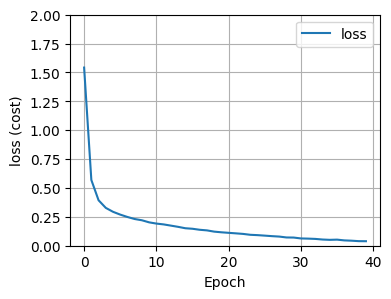

In [84]:
def plot_loss(history):
    plt.figure(figsize = (4,3))
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylim([0, 2])
    plt.ylabel('loss (cost)')
    plt.legend()
    plt.grid(True)
    plt.show()    

plot_loss(history)

### Predictions

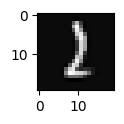

1/1 [==============================] - 0s 28ms/step
#Prediction: 
[[-12.01   0.08   3.51  -1.29  -6.05 -10.85  -1.57  -3.22  -8.45  -9.59]]
 Largest Prediction index: 2

#Probability vector: 
[[1.75e-07 3.08e-02 9.54e-01 7.83e-03 6.75e-05 5.55e-07 5.94e-03 1.14e-03
  6.12e-06 1.96e-06]]
 Largest Probability index: 2


In [86]:
# Prediction
img = X[1015] # an image of 2

#display the img
plt.figure(figsize = (1,1))
plt.imshow(img.reshape((20,20)).T, cmap='gray')
plt.show()

# prediction is a vector of values largest of which is the predicted class (digit)
prediction = model.predict(img.reshape(1,400))  # prediction

print(f"#Prediction: \n{prediction}") 
print(f" Largest Prediction index: {np.argmax(prediction)}")

# If we want probabilities instead, we use softmax as follows
prediction_p = tf.nn.softmax(prediction)

print(f"\n#Probability vector: \n{prediction_p}")
print(f" Largest Probability index: {np.argmax(prediction_p)}")

### Show a sample of data with labels and predictions

1/1 [==============================] - 0s 26ms/step


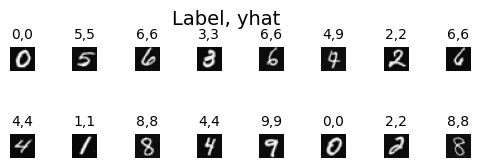

In [87]:
# Show a sample of data with predictions
show_image_grid(X, y, grid_w=8, grid_h=2, random_index=True, show_predictions=True)

### Show a sample of errors (wrong predictions)

157/157 [==============================] - 0s 2ms/step
There are 21 mistakes in the predictions. Showing some wrong predictions
1/1 [==============================] - 0s 26ms/step


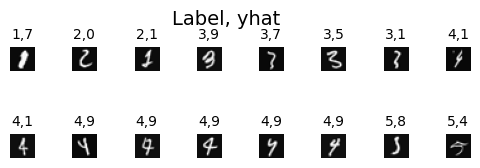

In [88]:
# Show some mistaken predictions
preds = model.predict(X)
yhat = np.argmax(preds, axis=1)
idxs = np.where(yhat != y[:,0])[0]
mistakes = X[idxs]
mistake_count = mistakes.shape[0]
if mistake_count > 0:
    print(f'There are {mistake_count} mistakes in the predictions. Showing some wrong predictions')
    show_image_grid(mistakes, y[idxs], grid_w=8, grid_h=2, show_predictions=True)
else:
    print('No mistaken predictions')

In [89]:
### Try to predict the output of my own digit image (gives wrong prediction)

(292, 301)


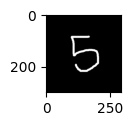

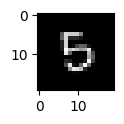

(20, 20)
1/1 [==============================] - 0s 80ms/step
#Prediction: 
[[ -254.13  -487.38  -644.24 -1014.59   405.33  -699.39    46.9    -42.68
   -767.7     60.46]]
 Largest Prediction index: 4

#Probability vector: 
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
 Largest Probability index: 4


In [90]:
from PIL import Image

im = Image.open(r"./my_5.png")
print(im.size)

#display the img
plt.figure(figsize = (1,1))
plt.imshow(im, cmap='gray')
plt.show()

resized = im.resize((20,20))
resized = resized.convert("L") # convert to gray scale
resized_np = np.array(resized)

plt.figure(figsize = (1,1))
plt.imshow(resized_np, cmap='gray')
plt.show()


print(resized_np.shape)
# prediction is a vector of values largest of which is the predicted class (digit)
prediction = model.predict(resized_np.reshape(1,400))  # prediction

print(f"#Prediction: \n{prediction}") 
print(f" Largest Prediction index: {np.argmax(prediction)}")

# If we want probabilities instead, we use softmax as follows
prediction_p = tf.nn.softmax(prediction)

print(f"\n#Probability vector: \n{prediction_p}")
print(f" Largest Probability index: {np.argmax(prediction_p)}")